# TensorFlow - MNIST - AutoEncoder

---

# 目標
* `encoder` 這部分練習使用深度網路進行更好的降維作業
* `decoder` 這部分將降維目標解譯
* 實現一個編碼器模型, 該模型為`非監督式`
* 使用該模型生成新資料

# 目錄
### [1 載入資料](#1.-載入資料)
### [2 模型建構](#2.-模型建構)
[2.1 tanh層, bn層](#2.1-tanh層,-bn層)  
[2.2 encoder](#2.2-encoder)  
[2.3 decoder](#2.3-decoder)  
[2.4 誤差](#2.4-誤差)  
[2.5 訓練](#2.5-訓練)  
[2.6 評估](#2.6-評估)  
[2.7 參數](#2.7-參數)  
[2.8 模型訓練](#2.8-模型訓練)  
### [3 模型測試](#3.-模型測試)
[3.1 encoder 編碼能力比較](#3.1-encoder-編碼能力比較)  
[3.2 模型能力比較](#3.2-模型能力比較)  
[3.3 模型解析](#3.3-模型解析)  
[3.4 分類應用](#3.4-分類應用)  
[3.5 假資料](#3.4-分類應用)

## 1. 載入資料

In [1]:
# 這裡大家很熟悉, 應該不用再介紹了
import time, os, input_data
mnist = input_data.read_data_sets('datasets', one_hot=False)

Extracting datasets\train-images-idx3-ubyte.gz
Extracting datasets\train-labels-idx1-ubyte.gz
Extracting datasets\t10k-images-idx3-ubyte.gz
Extracting datasets\t10k-labels-idx1-ubyte.gz


## 2. 模型建構

In [2]:
import tensorflow as tf
from tensorflow.python import control_flow_ops
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


### 2.1 tanh層, bn層

In [4]:
def layer(input, weight_shape, bias_shape, phase_train):
    '''這邊我們定義了基本的層, 為了不要過度的進行非線性轉化使之難以復原, 使用的是tanh(效果較sigmoid好些)'''
    weight_init = tf.random_normal_initializer(stddev=(1.0/weight_shape[0])**0.5)
    bias_init = tf.constant_initializer(0)
    
    w = tf.get_variable('w', weight_shape, initializer=weight_init)
    b = tf.get_variable('b', bias_shape, initializer=bias_init)
    
    logits = tf.matmul(input, w) + b
    
    return tf.nn.tanh(layer_batch_norm(logits, weight_shape[1], phase_train))

In [5]:
def layer_batch_norm(x, n_out, phase_train):
    '''
    定義 bn, 由於前面我們使用keras快速介紹, 現在可以仔細觀察 bn 裡面究竟做了些甚麼.
    如果實在不想看 bn 的代碼, 好消息是可以直接使用 tf.layers.batch_normalization()
    '''
    beta_init = tf.constant_initializer(0., dtype=tf.float32)
    gamma_init = tf.constant_initializer(1., dtype=tf.float32)
    
    beta = tf.get_variable('beta', [n_out], initializer=beta_init)
    gamma= tf.get_variable('gamma',[n_out], initializer=gamma_init)
    
    b_mean, b_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(0.9)
    ema_apply_op = ema.apply([b_mean, b_var])
    ema_mean, ema_var = ema.average(b_mean), ema.average(b_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(b_mean), tf.identity(b_var)
    
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

### 2.2 encoder

In [6]:
def encoder(x, n_code, phase_train):
    '''
    設計第一個模型, 這裡會把輸入資料做降維處理.
    由於是圖像資料, 其實可以用CNN效果更好.
    考量到盡量寫最簡單模型, 因此只用 Dense層+BN層
    '''
    with tf.variable_scope('encoder'):
        with tf.variable_scope('hidden_1'):
            hidden_1 = layer(x, [784, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
        
        with tf.variable_scope('hidden_2'):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
        
        with tf.variable_scope('hidden_3'):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)
            
        with tf.variable_scope('code'):
            code = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)
        
        return code

### 2.3 decoder

In [7]:
def decoder(code, n_code, phase_train):
    '''這裡定義第二個模型, 將前面的降維操作反轉, 試圖重建原始輸入.'''
    with tf.variable_scope('decoder'):
        with tf.variable_scope('hidden_1'):
            hidden_1 = layer(code, [n_code, n_decoder_hidden_1], [n_decoder_hidden_1], phase_train)
        
        with tf.variable_scope('hidden_2'):
            hidden_2 = layer(hidden_1, [n_decoder_hidden_1, n_decoder_hidden_2], [n_decoder_hidden_2], phase_train)
        
        with tf.variable_scope('hidden_3'):
            hidden_3 = layer(hidden_2, [n_decoder_hidden_2, n_decoder_hidden_3], [n_decoder_hidden_3], phase_train)
        
        with tf.variable_scope('output'):
            output = layer(hidden_3, [n_decoder_hidden_3, 784], [784], phase_train)
            
    return output        

### 2.4 誤差

In [8]:
def loss(output, x):
    '''
    設定誤差函數, 由於這是一個非監督式模型, 因此要由輸出與輸入來計算誤差.
    '''
    with tf.variable_scope('training'):
        l2 = tf.sqrt( tf.reduce_sum( tf.square( tf.subtract(output, x)), 1 ) )                                
        train_loss = tf.reduce_mean(l2, name='loss')
        train_summary_op = tf.summary.scalar('train_cost', train_loss)
        
        return train_loss, train_summary_op

### 2.5 訓練

In [9]:
def training(cost, global_step):
    '''定義模型的訓練過程'''
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(cost, global_step)
    
    return train_op

### 2.6 評估

In [10]:
def img_summary(summary_label, tensor):
    '''將輸入轉為圖片格式(shape=(28,28), dtype=uint8)'''
    tensor_reshaped = tf.reshape(tensor, [-1, 28, 28, 1])
    return tf.summary.image(summary_label, tensor_reshaped)

In [11]:
def evaluate(output, x):
    '''定義評價方法, 回傳 輸入的圖, 輸出的圖以及誤差'''
    with tf.variable_scope('validation'):
        in_im_op = img_summary('input_img', x)
        out_im_op =  img_summary('output_img', output)
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name='val_diff')), 1))
        val_loss = tf.sqrt(tf.reduce_mean(l2))
        val_summary_op = tf.summary.scalar('val_cost', val_loss)
        return val_loss, in_im_op, out_im_op, val_summary_op

### 2.7 參數

In [2]:
n_encoder_hidden_1 = 256
n_encoder_hidden_2 = 128
n_encoder_hidden_3 = 56
n_decoder_hidden_1 = 56
n_decoder_hidden_2 = 128
n_decoder_hidden_3 = 256

In [3]:
learning_rate = 0.01
training_epochs = 100
batch_size = 64
display_step = 1

### 2.8 模型訓練

In [13]:
n_code=3
pu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)  
with tf.Graph().as_default():
    with tf.variable_scope('auto_encoder_model'):
        
        x = tf.placeholder('float', [None, 784], name='x')
        phase_train = tf.placeholder(tf.bool, name='phase_train')
        
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        
        cost, train_summary_op = loss(output, x)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = training(cost, global_step)
        eval_op, in_im_op, out_im_op, val_summary_op = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        saver = tf.train.Saver(max_to_keep=5)
        
        train_writer = tf.summary.FileWriter('mnist_autoencoder_hidden='+str(n_code)+'_logs/', graph=tf.get_default_graph())
        val_writer = tf.summary.FileWriter('mnist_autoencoder_hidden='+str(n_code)+'_logs/', graph=tf.get_default_graph())
        
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        for epoch in range(training_epochs):
            total = mnist.train.num_examples//batch_size
            for i in range(total):
                mbatch_x, mbatch_y = mnist.train.next_batch(batch_size)
                _, train_summary = sess.run([train_op, train_summary_op], feed_dict={x:mbatch_x, phase_train:True})
                train_writer.add_summary(train_summary, sess.run(global_step))
                
            if epoch % display_step == 0:
                validation_loss, in_im, out_im, val_summary = sess.run([eval_op, in_im_op, out_im_op, val_summary_op],
                                                                      feed_dict={x:mnist.validation.images, phase_train:False})
                val_writer.add_summary(in_im, sess.run(global_step))
                val_writer.add_summary(out_im, sess.run(global_step))
                val_writer.add_summary(val_summary, sess.run(global_step))
                print('Epoch:', '%04d' % (1+epoch), 'Validation Loss:', validation_loss)
                
                saver.save(sess, 'mnist_autoencoder_hidden='+ 
                           str(n_code) +'_logs/model-checkpoint-'+
                           '%04d'%(epoch+1), global_step)
                    
        print('Optimization Finished')
        
        test_loss = sess.run(eval_op, feed_dict={x:mnist.test.images, phase_train:False})
        print('Test Loss:', test_loss)

Epoch: 0001 Validation Loss: 2.80385
Epoch: 0002 Validation Loss: 2.54577
Epoch: 0003 Validation Loss: 2.47315
Epoch: 0004 Validation Loss: 2.42818
Epoch: 0005 Validation Loss: 2.41102
Epoch: 0006 Validation Loss: 2.36528
Epoch: 0007 Validation Loss: 2.33781
Epoch: 0008 Validation Loss: 2.30889
Epoch: 0009 Validation Loss: 2.28411
Epoch: 0010 Validation Loss: 2.27318
Epoch: 0011 Validation Loss: 2.27001
Epoch: 0012 Validation Loss: 2.24968
Epoch: 0013 Validation Loss: 2.24127
Epoch: 0014 Validation Loss: 2.23635
Epoch: 0015 Validation Loss: 2.22496
Epoch: 0016 Validation Loss: 2.22336
Epoch: 0017 Validation Loss: 2.21513
Epoch: 0018 Validation Loss: 2.2115
Epoch: 0019 Validation Loss: 2.20671
Epoch: 0020 Validation Loss: 2.20603
Epoch: 0021 Validation Loss: 2.19798
Epoch: 0022 Validation Loss: 2.19701
Epoch: 0023 Validation Loss: 2.19638
Epoch: 0024 Validation Loss: 2.19077
Epoch: 0025 Validation Loss: 2.1897
Epoch: 0026 Validation Loss: 2.18895
Epoch: 0027 Validation Loss: 2.18368
Epo

## 3. 模型測試

In [11]:
# 開啟會話, 並執行所有起手式:
# 讀圖, 讀權重, 拿預設圖, 拿佔位符
sess = tf.Session()
saver = tf.train.import_meta_graph('mnist_autoencoder_hidden=3_logs/model-checkpoint-0100-85900.meta')
saver.restore(sess, tf.train.latest_checkpoint('mnist_autoencoder_hidden=3_logs'))
g = tf.get_default_graph()
x = g.get_tensor_by_name('auto_encoder_model/x:0')
phase_train = g.get_tensor_by_name('auto_encoder_model/phase_train:0')

# 拿我們想要的節點
decoder_output = g.get_tensor_by_name('auto_encoder_model/decoder/output/Tanh:0')
encoder_output = g.get_tensor_by_name('auto_encoder_model/encoder/code/Tanh:0')

# 丟我們的資料進入跑結果
model_codes = sess.run(encoder_output, feed_dict={x:mnist.test.images, phase_train:False})
model_recon = sess.run(decoder_output, feed_dict={x:mnist.test.images, phase_train:False})

# 印出來shape看一下
print(model_codes.shape, model_recon.shape)

INFO:tensorflow:Restoring parameters from mnist_autoencoder_hidden=3_logs\model-checkpoint-0100-85900
(10000, 3) (10000, 784)


In [12]:
# PCA, 同樣是執行降維以及還原的演算法, 拿來做對比
pca = PCA(n_components=3)
pca.fit(mnist.train.images)
pca_codes = pca.transform(mnist.test.images)
pca_recon = pca.inverse_transform(pca_codes)

# 同樣印出shape, 跟我們的結果都一樣, 我們接下來來看差異
print(pca_codes.shape, pca_recon.shape)

(10000, 3) (10000, 784)


### 3.1 encoder 編碼能力比較

In [13]:
# 首先我們定義了10個顏色, 接下來要對應10個類別給不同顏色
colors = ['#AAAAAA',
          '#FF88C2',
          '#FF5511',
          '#FFFF33',
          '#227700',
          '#77FFEE',
          '#0000AA',
          '#9900FF',
          '#000000']

In [14]:
# 如果想要轉動3D座標, 可以使用第二行程式碼

# 圖片結果顯示在jupyter內
%matplotlib inline  

# 圖片結果在新視窗顯示
# %matplotlib qt      

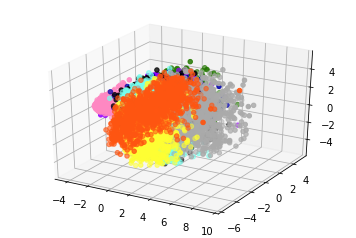

In [15]:
# 用3D散點圖繪製PCA降維成果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, color in enumerate(colors):
    pca_num = np.array([pca_codes[idx] for idx, label in enumerate(mnist.test.labels) if label==i])
    ax.scatter(pca_num[:, 0], pca_num[:, 1], pca_num[:, 2], c=color, marker='o')

plt.show()

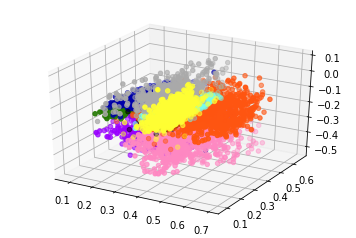

In [16]:
# 用3D散點圖繪製深度模型降維結果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, color in enumerate(colors):
    model_num = np.array([model_codes[idx] for idx, label in enumerate(mnist.test.labels) if label==i])
    ax.scatter(model_num[:, 0], model_num[:, 1], model_num[:, 2], c=color, marker='o')

plt.show()

我們從兩個圖中可以清楚看到, PCA降維的成果我們是沒辦法正確區分各個類別.  
相對的, 模型降維後很大的程度將不同的類別分不同的群組放在這個三維的空間中.  

## 3.2 模型能力比較

雖然我們看到了模型前半段的差異, 但是這並不能證明我們整體就比較優秀.  
因此還是要直接看整個模型的差異.

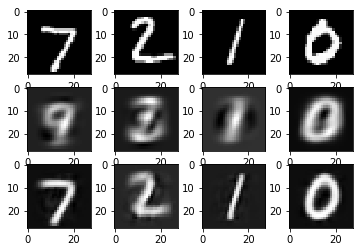

In [17]:
# 取test資料的前四筆, 比較結果
fig, axes = plt.subplots(3, 4)

for j in range(4):
    # 先畫出原圖
    axes[0][j].imshow(mnist.test.images[j].reshape((28,28)), cmap=plt.cm.gray)
    
    # 畫出PCA還原的圖
    axes[1][j].imshow(pca_recon[j].reshape((28, 28)), cmap=plt.cm.gray)
    
    # 畫出模型還原的圖
    axes[2][j].imshow(model_recon[j].reshape((28,28)), cmap=plt.cm.gray)

這個就非常清楚了, 模型能夠還原出很高質量的圖片.  
事實上如果使用的是CNN模型架構, 或許能夠還原的更清楚.

## 3.3 模型解析

由於深度學習一直給人黑盒的印象, 因此特別寫了一段來看清楚各數字到底學會了什麼.  

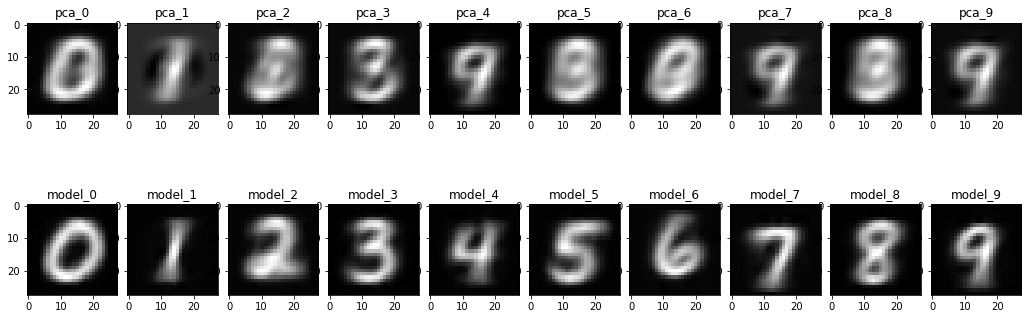

In [18]:
# 設計圖片數量為 2x10 
fig, axes = plt.subplots(2,10)
# 設定每個小圖的長寬
fig.set_size_inches(18, 5)
# 設定小圖間的上下間距
plt.subplots_adjust(wspace =0, hspace =1)

# 畫出 pca 跟 model 所學會對應 0~9 的特徵
for i in range(10):
    pca_num = np.asarray([pca_recon[idx] for idx, label in enumerate(mnist.test.labels) if label == i])
    pca_num = pca_num.mean(axis=0)
    
    model_num = np.asarray([model_recon[idx] for idx, label in enumerate(mnist.test.labels) if label == i])
    model_num = model_num.mean(axis=0)
            
    axes[0][i].set_title('pca_'+str(i))
    axes[1][i].set_title('model_'+str(i))
    axes[0][i].imshow(pca_num.reshape((28,28)), cmap=plt.cm.gray)
    axes[1][i].imshow(model_num.reshape((28,28)), cmap=plt.cm.gray)

plt.show()

圖中顯示的是從 0~9 學會的樣子, 可以很清楚看到模型確實已經學會了 0~9.  
而PCA在比較複雜的數字就不能很好的分辨, 這其實是因為pca使用的是線性轉換, 而deep model是非線性的.  

### 3.4 分類應用

由於非監督的關係, 我們並沒有告訴模型到底傳進的是什麼, 模型只能夠還原原本的圖片.  
但是其實我們還是可以事後傳進標準圖片來獲得答案.  
這是什麼意思呢, 先看一下下方的程式跟結果.

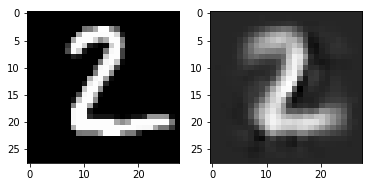

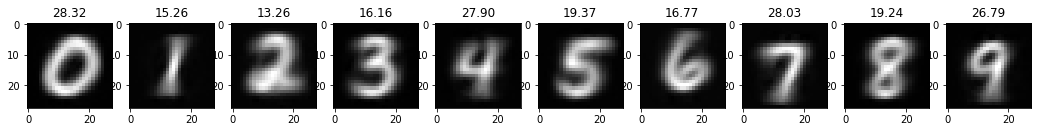

In [19]:
n=1   # 隨便選一張圖

# 畫出原始圖
fig, axes = plt.subplots(1,2)
img = mnist.test.images[n]

# 畫出輸出圖
axes[0].imshow(img.reshape((28, 28)), cmap=plt.cm.gray)
axes[1].imshow(model_recon[n].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

# 畫出模型所學會的 0~9 , 分別計算輸入的圖與 0~9 的誤差
fig, axes = plt.subplots(1,10)
fig.set_size_inches(18, 5)
for i in range(10):
    model_num = np.asarray([model_recon[idx] for idx, label in enumerate(mnist.test.labels) if label == i])
    model_num = model_num.mean(axis=0)
    
    loss = (((model_recon[n] - model_num)**2).sum())**1/2
        
    axes[i].set_title('{:.2f}'.format(loss))
    axes[i].imshow(model_num.reshape((28,28)), cmap=plt.cm.gray)
plt.show()

我們可以看到模型將圖片還原後計算了每個類別一個誤差.  
我們可以透過這個誤差得到現在這個輸入到底是哪個數字.  
像上面我們輸入2, 而這張圖與2的誤差最小, 我們就可以判斷這個數字是2

### 3.5 假資料

事實上我們如果拿這個來進行分類應用..  
真的很浪費, 因為我們只需要進行到前半就可以很準確的分類了.  
反轉後生成圖片在拿來分類其實基本上只會降低準確度而已...  
這個模型真正的用途其實是拿來生成假資料的.  
詳細看下方程式碼.

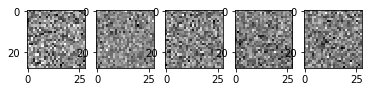

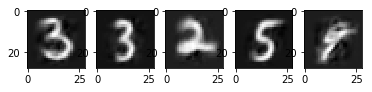

In [20]:
# 隨機生成 5 筆隨機資料並將他們畫出來
rand_sample = np.random.normal(0, 1, (5, 784))
fg, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(rand_sample[i].reshape((28, 28)), cmap=plt.cm.gray)
plt.show()

# 拿節點, 運行
decoder_output = g.get_tensor_by_name('auto_encoder_model/decoder/output/Tanh:0')
rand_recon = sess.run(decoder_output, feed_dict={x:rand_sample, phase_train:False})

# 將結果畫出來
fg, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(rand_recon[i].reshape((28, 28)), cmap=plt.cm.gray)
plt.show()

可以看到, 我們拿著亂七八糟的東西給模型, 卻做出了有如真人手寫一般的資料.  
就是使用這個機制, 我們可以擴增這個想法, 在任何的場合設計出假資料模型(?)

In [21]:
# 不要忘記關閉哦~
sess.close()